In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from importlib import reload

import Tree
reload(Tree)
from Tree import *

import forecast_prophet
reload(forecast_prophet)
from forecast_prophet import *

import forecast_ucm
reload(forecast_ucm)
from forecast_ucm import *

import utils
reload(utils)
from utils import *

import main
reload(main)
from main import *

path='c:\\Users\\31683\\Desktop\\data\\M5'
Y_path=path+f"\\sales_train_validation.pkl"  # to data file 
Y_path_eval=path+f"\\sales_train_evaluation.pkl" 

price_path=path+f"\\prices_train_val_eval.pkl"
# X_path_val_eval=path+f"\\prices_train_val_eval.pkl"  # to data file


df_data=pd.read_pickle(Y_path)
df_data.iloc[:,:4]=df_data.iloc[:,:4].astype('string') # change the type to string so that groupby maintains store and dept ids
df_data.drop(columns=['2011-01-29','2011-01-30'],inplace=True) #start on Monday

df_holidays=pd.read_csv(path+f"\\holidays.csv")
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

df_price=pd.read_pickle(price_path,compression='gzip')
df_price.drop(columns=['2011-01-29','2011-01-30'],inplace=True)

df_snap=pd.read_csv(path+f"\\calendar.csv")[['snap_CA','snap_WI','snap_TX']]
df_snap.columns=[['CA','WI','TX']]
df_snap=df_snap[2:].reset_index()
df_snap.T.columns=df_price.columns[5:]
df_snap=pd.merge(df_price.iloc[:,:5],df_snap.T,left_on='state_id',right_index=True)

vW=np.loadtxt(path+f"\\weights.txt")  #m5 competition weights
vW=vW[:114]  #drop subsetting if product level data is added

#delete below if item level is added
df_price=df_price.groupby(['state_id','store_id','cat_id','dept_id']).mean().reset_index()
df_price=df_price.drop(columns=['item_id'])
df_snap=df_snap.groupby(['state_id','store_id','cat_id','dept_id']).max().reset_index()
df_snap=df_snap.drop(columns=['item_id'])

tree_spatial=Tree( dfData = df_data , sType='spatial') 
slices = [len([sublist for sublist in tree_spatial.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_spatial.levels)]
slices.append(1)
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_ucm.pkl', 'rb') as file:
    ddOutputs_spatial_ucm= pickle.load(file)  
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial_prophet = pickle.load(file) 

c:\Users\31683\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


In [23]:
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_ucm.pkl', 'rb') as file:
    ddOutputs_spatial_ucm= pickle.load(file)  
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial_prophet = pickle.load(file) 

In [25]:
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_ucm_3.pkl', 'rb') as file:
    ddOutputs_spatial_ucm= pickle.load(file)  
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial_prophet = pickle.load(file) 

In [29]:
if 'wls_var' in ddOutputs_spatial_ucm:
    ddOutputs_spatial_ucm['wls'] = ddOutputs_spatial_ucm.pop('wls_var')

In [30]:
metric='RMSE'

df1=getCVResults( h=7, iOoS=7, ddOutputs=ddOutputs_spatial_prophet , metric=metric , slices=slices , rolling=True, relative=False, iters=None).drop(columns=['top_down_ph','top_down_hp'])
df6=getCVResults( h=7, iOoS=7, ddOutputs=ddOutputs_spatial_ucm , metric=metric , slices=slices , rolling=True, relative=False, iters=None).drop(columns=['top_down_ph','top_down_hp'])
df2=getCVResults( h=7, iOoS=7, ddOutputs=ddOutputs_spatial_prophet , metric=metric , slices=slices , rolling=True, relative=False, iters=None, predicted='hat').drop(columns=['top_down_ph','top_down_hp'])
df7=getCVResults( h=7, iOoS=7, ddOutputs=ddOutputs_spatial_ucm , metric=metric , slices=slices , rolling=True, relative=False, iters=None, predicted='hat').drop(columns=['top_down_ph','top_down_hp'])




row_tuples = list(itertools.product(df1.index, df1.columns.get_level_values(0).unique()))
row_index=pd.MultiIndex.from_tuples( row_tuples ,names=['Level','Method'])

dfComparison = pd.DataFrame(index=row_index, columns=['Prophet', 'UCM' , 'Prophet_base','UCM_base'
                                                    #   ,'ST_TDHP_i40', "ST_mint_shrink",   "ST_mint_sample"
                                                    #   ,  "Spatial_UCM"
                                                       ])
for i,df in enumerate([df1,df6,df2,df7]): 
    for index in dfComparison.index:
        dfComparison.loc[index][i]=df.loc[index[0],index[1]]

dfComparison

Prophet     UCM Prophet_base UCM_base
Level   Method                                           
Total   bottom_up   3978.07 6946.90      3692.63  5092.59
        wls         3686.03 5845.25      3692.63  5092.59
        ols         3663.65 5150.26      3692.63  5092.59
        mint_sample 3723.11 3971.86      3692.63  5092.59
        mint_shrink 3652.76 4136.81      3692.63  5092.59
        mint_diag   3611.74 5845.25      3692.63  5092.59
State   bottom_up   2706.40 4302.07      2445.87  3224.76
        wls         2450.93 3668.81      2445.87  3224.76
        ols         2438.75 3270.35      2445.87  3224.76
        mint_sample 2467.17 2617.60      2445.87  3224.76
        mint_shrink 2424.62 2709.86      2445.87  3224.76
        mint_diag   2439.66 3668.81      2445.87  3224.76
Store   bottom_up   1948.70 2539.77      1887.59  2391.75
        wls         1854.19 2253.76      1887.59  2391.75
        ols         1734.85 2087.33      1887.59  2391.75
        mint_sample 1561.02 1675.60      1887.59  2391.75
        mint_shrink 1554.14 1777.76      1887.59  2391.75
        mint_diag   1635.77 2253.76      1887.59  2391.75
Cat.    bottom_up   1637.78 1905.38      1439.81  1848.87
        wls         1619.97 1744.79      1439.81  1848.87
        ols         1435.12 1687.94      1439.81  1848.87
        mint_sample 1279.82 1371.29      1439.81  1848.87
        mint_shrink 1274.02 1476.22      1439.81  1848.87
        mint_diag   1360.87 1744.79      1439.81  1848.87
Dept.   bottom_up   1329.64 1462.76      1329.64  1462.76
        wls         1572.59 1399.47      1329.64  1462.76
        ols         1251.47 1357.48      1329.64  1462.76
        mint_sample 1041.27 1125.13      1329.64  1462.76
        mint_shrink 1041.34 1211.80      1329.64  1462.76
        mint_diag   1161.49 1399.47      1329.64  1462.76
Average bottom_up   5603.33 8887.51      5198.24  6900.14
        wls         5303.70 7596.66      5198.24  6900.14
        ols         5099.54 6802.15      5198.24  6900.14
        mint_sample 5010.73 5346.17      5198.24  6900.14
        mint_shrink 4933.99 5591.48      5198.24  6900.14
        mint_diag   4987.32 7596.66      5198.24  6900.14

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
levels = ['Total', 'State', 'Store', 'Cat.', 'Dept.', 'Average']
methods = ['bottom_up', 'wls', 'ols', 'mint_sample', 'mint_shrink', 'mint_diag']

data = {
    'Level': sum([[lvl] * len(methods) for lvl in levels], []),
    'Method': methods * len(levels),
    'Prophet': dfComparison['Prophet'].values,
    'UCM': dfComparison['UCM'].values,
    'Prophet_base': dfComparison['Prophet_base'].values,
    'UCM_base': dfComparison['UCM_base'].values
}

df = pd.DataFrame(data)




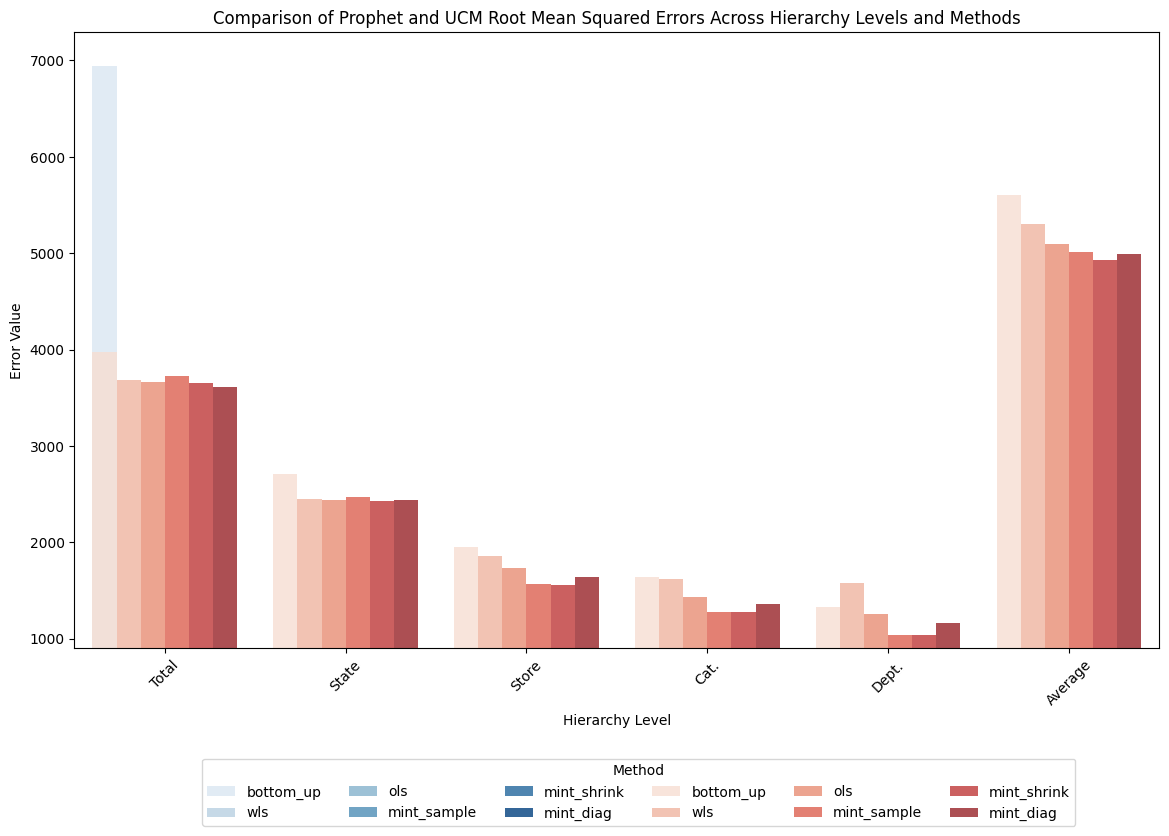

In [28]:
# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=df, x='Level', y='UCM', hue='Method', palette='Blues',alpha=0.9, dodge=True)
sns.barplot(data=df, x='Level', y='Prophet', hue='Method', palette='Reds', alpha=0.8, dodge=True)

# Add Prophet_base and UCM_base as bold lines
sns.barplot(data=df, x='Level', y='UCM_base', palette=None, alpha=0.7,fill=False)
sns.barplot(data=df, x='Level', y='Prophet_base', palette=None, alpha=0.7 , fill=False)

plt.xlabel('Hierarchy Level')
plt.ylabel('Error Value')
plt.title('Comparison of Prophet and UCM Root Mean Squared Errors Across Hierarchy Levels and Methods')
plt.xticks(rotation=45)
plt.ylim(900)
plt.legend(title='Method', bbox_to_anchor=(0.52, -0.3), loc='lower center', ncol=6)
plt.show()